In [48]:
import numpy as np
import pandas as pd
import h5py
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm
from scipy import stats

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu

# Load metadata

In [2]:
CHROMS = [str(i) for i in list(range(1,23)) + ["X"]]

CHROMSIZES = 'hg19_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(sum).to_dict()
BLACKLIST = 'hg19.blacklist.bed'

BINSIZE = 100_000

# Load data (available on GEO: GSE247458)

In [3]:
import scanpy as sc

_single-cell_

In [4]:
sc_100kb_adata = sc.read_h5ad('sc_damchic_human_binsize_100000.h5ad.gz')

sc_100kb_adata

AnnData object with n_obs × n_vars = 5055 × 30376
    obs: 'limsid', 'indexnr', 'barcodenr', 'construct', 'antibody', 'assay', 'cell_type', 'species', 'condition', 'cellcount', 'dam_counts', 'chic_counts', 'dam_counts_cas', 'dam_counts_129', 'chic_counts_cas', 'chic_counts_129', 'cellcycle_phase_via_facs', 'hoechst', 'cellcycle_phase_via_hoechst'
    layers: 'scDamID', 'sortChIC'

_input control_

In [5]:
input_1kb_adata = sc.read_h5ad('input_human_binsize_1000.h5ad.gz')

input_1kb_adata

AnnData object with n_obs × n_vars = 2 × 3036315
    layers: 'input'

_LAD calls_

In [6]:
lads = pd.read_csv('damchic_kbm7_consensus_lads.bed', sep='\t', header=None)
lads_dict = {c: np.zeros((chromsizes[c]//BINSIZE)+1, dtype=bool) for c in CHROMS}
for c,s,e in lads.values:
    lads_dict[c][s//BINSIZE:e//BINSIZE] = True
    
lads1d = np.hstack(list(lads_dict.values()))
ladsize = np.diff(lads[[1,2]]).reshape(-1,)

lads[3] = np.diff(lads[[1,2]], axis=1)

# Formatting

In [7]:
var_names = pd.Series(sc_100kb_adata.var_names)
damid_100kb_counts = {bc: dict() for bc in sc_100kb_adata.obs_names}
chic_100kb_counts = {bc: dict() for bc in sc_100kb_adata.obs_names}

for chrom in tqdm(CHROMS):
    idx = var_names.str.startswith('%s_' %chrom)
    damid_layer = sc_100kb_adata.layers['scDamID'][:,idx]
    chic_layer = sc_100kb_adata.layers['sortChIC'][:,idx]
    for i,bc in enumerate(sc_100kb_adata.obs_names):
        damid_100kb_counts[bc][chrom] = damid_layer[i]
        chic_100kb_counts[bc][chrom] = chic_layer[i]

  0%|          | 0/23 [00:00<?, ?it/s]

In [8]:
var_names = pd.Series(input_1kb_adata.var_names)
input_1kb_counts = {bc: dict() for bc in input_1kb_adata.obs_names}

for chrom in tqdm(CHROMS):
    idx = var_names.str.startswith('%s_' %chrom)
    input_layer = input_1kb_adata.layers['input'][:,idx]
    for i,bc in enumerate(input_1kb_adata.obs_names):
        input_1kb_counts[bc][chrom] = input_layer[i]

  0%|          | 0/23 [00:00<?, ?it/s]

_Rebin input control_

In [9]:
input_100kb_counts = scct.rebinning(input_1kb_counts, binsize=1_000, rebinsize=100_000)

_Observed / Expected_

In [10]:
scct.compute_oe

<function scChromTools.compute_oe(counts_iter, binsize, chromsizes, depth_thrs=1000, pseudocount=0.1, minmap_per_kb=1, expected=None, blacklist=None, chroms=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'], scaling_factor=None, disable_tqdm=False)>

In [11]:
damid_100kb_oe, _ = scct.compute_oe(damid_100kb_counts, 
                                    100_000, 
                                    CHROMSIZES, 
                                    0, 
                                    expected=input_100kb_counts['GATC'], 
                                    blacklist=BLACKLIST
)

  0%|          | 0/5055 [00:00<?, ?it/s]

/Users/prullens/Documents/GitHub/scChromTools/local/scChromTools.py:141: RuntimeWarning: invalid value encountered in divide
  scrpkm = {c: counts[c] / depth * 1e9 / binsize for c in chroms}


In [12]:
chic_100kb_oe, _ = scct.compute_oe(chic_100kb_counts, 
                                   100_000, 
                                   CHROMSIZES, 
                                   0, 
                                   expected=input_100kb_counts['MNase_H3'], 
                                   blacklist=BLACKLIST
)

  0%|          | 0/5055 [00:00<?, ?it/s]

_Mild gaussian kernal smoothing_

In [13]:
damid_100kb_oe_smooth = scct.gaussian_smoothing(damid_100kb_oe, BINSIZE, 150_000, disable_tqdm=False)

  0%|          | 0/5055 [00:00<?, ?it/s]

In [14]:
chic_100kb_oe_smooth = scct.gaussian_smoothing(chic_100kb_oe, BINSIZE, 150_000, disable_tqdm=False)

  0%|          | 0/5055 [00:00<?, ?it/s]

# Plot settings

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

kwargs = {'dpi':150}

coldict_cmap = {'None':'black',
                'scDamID':'lime',
                'sortChIC':'magenta',
                'Both':'white'
}
coldict = {'None':'black',
           'scDamID':'#00CC00',
           'sortChIC':'#D500DB',
           'Both':'white'
}
_cmap =  cmap.from_list('cbar',list(coldict_cmap.values()))

violinprops = {'linewidth':1,
               'edgecolor':'k'
}
tick_kwargs = {'length':7}

# Plotting

In [16]:
#subset data of interest
anno = sc_100kb_adata.obs
anno.loc[anno['condition'] == 'DamChIC','condition'] = 'unsynchronized'

anno_sub = anno[(anno['assay'] == 'DamChIC') &
                (anno['construct'] == 'Dam-LMNB1') & 
                (anno['antibody'] == 'LMNB1') & 
                (anno['condition'] == 'unsynchronized')
]

anno_sub.head()

limsid indexnr barcodenr  construct antibody    assay  \
KIN6062.index10.007  KIN6062      10         7  Dam-LMNB1    LMNB1  DamChIC   
KIN6062.index10.009  KIN6062      10         9  Dam-LMNB1    LMNB1  DamChIC   
KIN6062.index10.011  KIN6062      10        11  Dam-LMNB1    LMNB1  DamChIC   
KIN6062.index10.012  KIN6062      10        12  Dam-LMNB1    LMNB1  DamChIC   
KIN6062.index10.015  KIN6062      10        15  Dam-LMNB1    LMNB1  DamChIC   

                    cell_type species       condition cellcount dam_counts  \
KIN6062.index10.007      KBM7   human  unsynchronized         1      26892   
KIN6062.index10.009      KBM7   human  unsynchronized         1      74007   
KIN6062.index10.011      KBM7   human  unsynchronized         1      36194   
KIN6062.index10.012      KBM7   human  unsynchronized         1       3748   
KIN6062.index10.015      KBM7   human  unsynchronized         1      21957   

                    chic_counts dam_counts_cas dam_counts_129 chic_counts_cas  \
KIN6062.index10.007       14038            nan            nan             nan   
KIN6062.index10.009        6883            nan            nan             nan   
KIN6062.index10.011        4702            nan            nan             nan   
KIN6062.index10.012        1565            nan            nan             nan   
KIN6062.index10.015        5923            nan            nan             nan   

                    chic_counts_129 cellcycle_phase_via_facs  hoechst  \
KIN6062.index10.007             nan                     S/G2    20734   
KIN6062.index10.009             nan                     S/G2    18831   
KIN6062.index10.011             nan                     S/G2    13350   
KIN6062.index10.012             nan                     S/G2  17529.0   
KIN6062.index10.015             nan                       G1     8711   

                    cellcycle_phase_via_hoechst  
KIN6062.index10.007                         nan  
KIN6062.index10.009                         nan  
KIN6062.index10.011                         nan  
KIN6062.index10.012                         nan  
KIN6062.index10.015                         nan

____

# Single-cell mirror plots

In [17]:
_bcs = ['KIN6062.index10.368',
       'KIN6062.index10.185',
       'KIN6062.index10.067',
       'KIN6062.index21.031',
       'KIN6062.index10.316'
]

Text(0.5, 0, 'Chromosome 1 (Mb)')

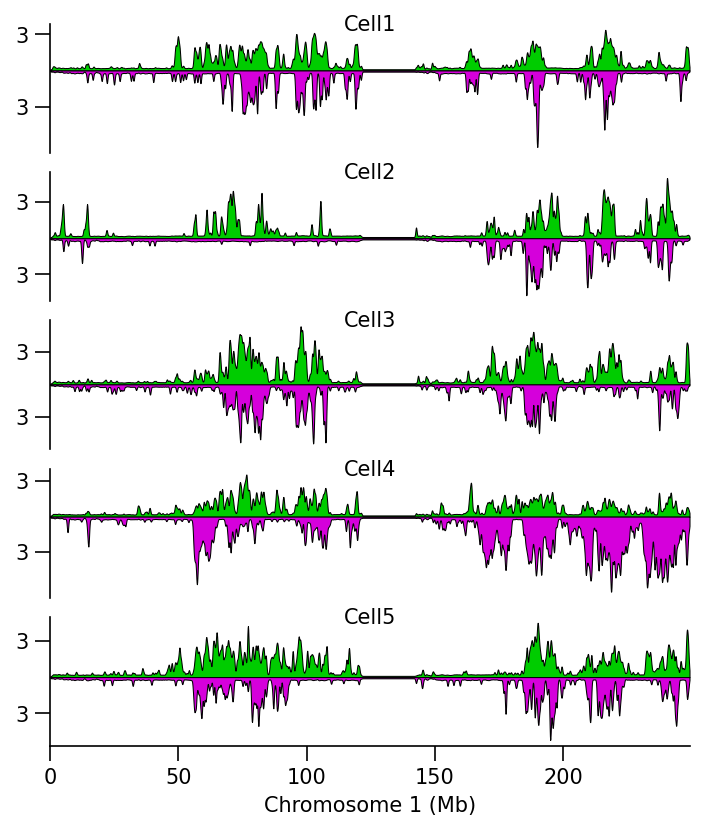

In [18]:
chrom = '1'

smooth_stddev = 250000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

xaxis = np.arange(0,chromsizes[chrom],BINSIZE) / 1e6

nrows, ncols = len(_bcs), 1
f, ax = plt.subplots(nrows, 
                     ncols, 
                     figsize=(5.5, 1.25*nrows), 
                     gridspec_kw={'hspace':0.15}, 
                     **kwargs
)
for i,bc in enumerate(_bcs):
    X = fftconvolve(damid_100kb_oe[bc][chrom], w, mode='same')
    y = fftconvolve(chic_100kb_oe[bc][chrom], w, mode='same')
    
    ax[i].fill_between(xaxis, 
                       X, 
                       color=coldict['scDamID'], 
                       lw=.5, 
                       edgecolor='k'
    )
    ax[i].fill_between(xaxis, 
                       y * -1, 
                       color=coldict['sortChIC'], 
                       lw=.5, 
                       edgecolor='k'
    )
    
    if i < (len(_bcs) - 1):
        ax[i].spines[['right','top','bottom']].set_visible(False)
        ax[i].set_xticks([])
    ax[i].set_title('Cell%i' %(i+1), fontsize=10, y=.85)
    ax[i].set_yticks([-3,3])
    ax[i].set_yticklabels([3,3])
    ax[i].margins(x=0)
    ax[i].tick_params(**tick_kwargs)
        
ax[-1].spines[['right','top']].set_visible(False)
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

_____

# Single-cell overlap heatmap

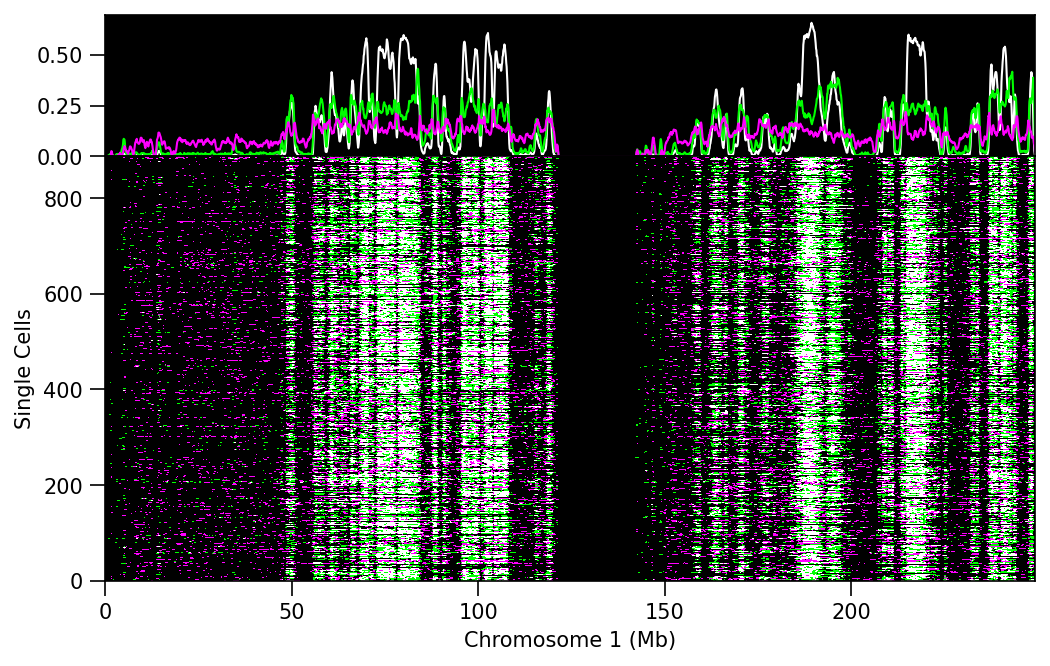

In [19]:
chrom = '1'

smooth_stddev = 250000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

X = np.array([fftconvolve(damid_100kb_oe[bc][chrom], w, mode='same') > 1 for bc in anno_sub.index], dtype=int)
y = np.array([fftconvolve(chic_100kb_oe[bc][chrom], w, mode='same') > 1 for bc in anno_sub.index], dtype=int)
Z = X + y + y

xaxis = np.arange(0,chromsizes[chrom],BINSIZE) / 1e6

f, ax = plt.subplots(2, 
                     1, 
                     figsize=(8,5), 
                     gridspec_kw={'hspace':.0, 'height_ratios':[.25,.75]}, 
                     **kwargs
)
for i,state in enumerate([3,1,2]):
    ax[0].plot(xaxis, 
               (Z == state).mean(0), 
               color=list(coldict_cmap.values())[state],
               lw=1
    )
    
ax[1].pcolorfast(xaxis, 
                 range(Z.shape[0]), 
                 Z, 
                 cmap=_cmap
)
ax[0].set_facecolor('k')
ax[0].set_ylim(0,.7)
ax[0].margins(x=0)
ax[0].set_xticks([])

ax[1].set_xlabel('Chromosome %s (Mb)' %chrom)
ax[1].set_ylabel('Single Cells')
ax[1].set_yticks(range(0,801,200))

for i in range(ax.size):
    ax[i].tick_params(**tick_kwargs)

______

# CF scatter

In [20]:
_bcs = anno_sub[(anno_sub['condition'] == 'unsynchronized') & 
                (anno_sub['dam_counts'].astype(int) >= 5e3)
].index

_bcs.size

690

In [21]:
cf_dam = {c: np.mean([damid_100kb_oe_smooth[bc][c] > 1 for bc in _bcs], axis=0) for c in CHROMS}
cf_chic = {c: np.mean([chic_100kb_oe_smooth[bc][c] > 1 for bc in _bcs], axis=0) for c in CHROMS}

In [22]:
#select mappable bins
damid_idx = np.hstack(list(damid_100kb_oe[list(damid_100kb_oe)[0]].values())) > .101
chic_idx = np.hstack(list(chic_100kb_oe[list(chic_100kb_oe)[0]].values())) > .101

mappab_idx = damid_idx & chic_idx

damid_idx.sum(), chic_idx.sum(), idx.sum()

(27787, 25455, 155271)

In [23]:
chroms1d = np.hstack([np.repeat(c,(chromsizes[c]//BINSIZE)+1) for c in CHROMS])

chroms1d.size

30376

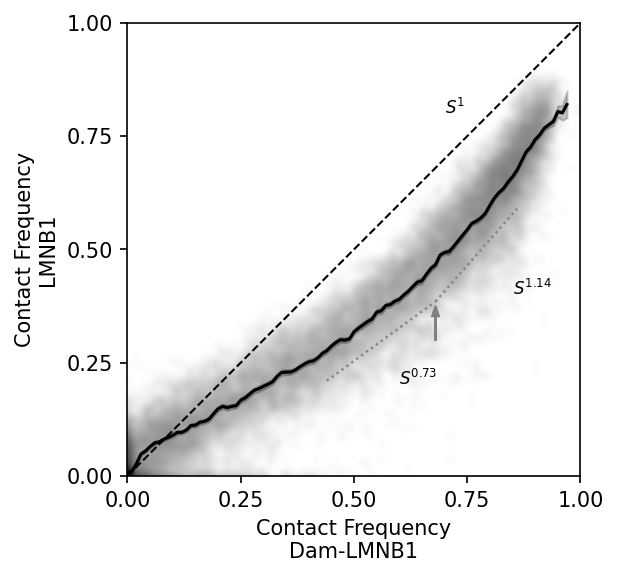

In [24]:
X = np.hstack(list(cf_dam.values()))
y = np.hstack(list(cf_chic.values()))

#background normalization 
a = 0 
b = X.max()
bg = X[mappab_idx & (chroms1d != '8') & ~lads1d].mean() #chr8 is dipload in KBM7

X = X[mappab_idx & (chroms1d != '8')]
X_scale = ((b - a) * ((X - bg) / (X.max() - bg))) + a
X_scale[X_scale < 0] = 0

a = 0 
b = y.max()
bg = y[mappab_idx & (chroms1d != '8') & ~lads1d].mean()

y = y[mappab_idx & (chroms1d != '8')]
y_scale = ((b - a) * ((y - bg) / (y.max() - bg))) + a
y_scale[y_scale < 0] = 0

xhat, yhat, yhat_sem = sccu.RNR(X_scale[(X_scale < .975)], y_scale[(X_scale < .975)], _RADIUS=.005, step=.01)
h, xedge, yedge = np.histogram2d(X_scale, y_scale, range=[[0,1],[0,1]], bins=120)
h = gaussian_filter(np.log2(h + 1).T, 1)

f, ax = plt.subplots(figsize=(4,4), 
                     **kwargs
)

ax.imshow(h, 
          interpolation='bilinear',
          origin='lower', 
          cmap='binary',
          extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], 
          vmax=8)
ax.plot(xhat, 
        yhat, 
        color='k', 
        lw=1.5
)
ax.fill_between(xhat, 
                yhat-yhat_sem, 
                yhat+yhat_sem, 
                color='k', 
                alpha=.2
)

ax.set_xlabel('Contact Frequency\nDam-LMNB1')
ax.set_ylabel('Contact Frequency\nLMNB1')
ax.plot([0,1],[0,1], ls='--', color='k', lw=1, zorder=0)
ax.set_xlim(-.0,1)
ax.set_ylim(-.0,1)

ax.text(.7, .8,'$S^%i$' %1, fontsize=8)

x1, x2, y1, y2 = .44, .68, .21, .385
ax.plot([x1,x2],[y1,y2], color='gray', ls=':', lw=1.1)

m = (y2 - y1) / (x2 - x1)
ax.text(.6, .2,"$S^{%.2f}$" %m, fontsize=8)

x1, x2, y1, y2 = .68, .86, .385, .59
ax.plot([x1,x2],[y1,y2], color='gray', ls=':', lw=1.1)

m = (y2 - y1) / (x2 - x1)
ax.text(.85, .4,"$S^{%.2f}$" %m, fontsize=8)

ax.set_xticks(np.arange(0,1.1,.25))
ax.set_yticks(np.arange(0,1.1,.25))

plt.arrow(.68, .3, 0, 0.075, length_includes_head=True, head_width=0.015, color='gray')

___

# ``scVelo`` chromatin velocity analysis

In [19]:
import scvelo as scv

In [20]:
X = np.log2([np.hstack(list(damid_100kb_oe_smooth[bc].values())) for bc in anno_sub.index])
y = np.log2([np.hstack(list(chic_100kb_oe_smooth[bc].values())) for bc in anno_sub.index])

X.shape, y.shape

((889, 30376), (889, 30376))

In [21]:
edges = np.diff(lads1d.astype(np.int8), prepend=0, append=0)
rising = np.where(edges == 1)[0]
falling = np.where(edges == -1)[0]

In [22]:
#single-cell LAD calling, 0 is None, 1 is scDamID-specific, 2 is sortChIC-specific, 3 is both
Z = (X > 0).astype(int) + (y > 0).astype(int) + (y > 0).astype(int)

event_counts = np.zeros((4,anno_sub.shape[0],lads.shape[0]))
for event in range(4):
    cum = np.insert(np.cumsum(Z == event, axis=1), 0, 0, axis=1)
    event_counts[event] = cum[:,falling] - cum[:,rising]
Zlads = np.argmax(event_counts, axis=0)
Xlads = ((Zlads == 1) | (Zlads == 3)).astype(int)
ylads = (Zlads >= 2).astype(int)

Zlads.shape

(889, 547)

In [23]:
cum = np.insert(np.cumsum(X, axis=1), 0, 0, axis=1) 
Xlads_l2oe = (cum[:, falling] - cum[:, rising]) / (falling - rising)

cum = np.insert(np.cumsum(y, axis=1), 0, 0, axis=1) 
ylads_l2oe = (cum[:, falling] - cum[:, rising]) / (falling - rising)

Xlads_l2oe_min = Xlads_l2oe.min(0).reshape(1,-1)
ylads_l2oe_min = ylads_l2oe.min(0).reshape(1,-1)

Xlads_l2oe += abs(Xlads_l2oe_min) #scVelo does not accept negetive floats 
ylads_l2oe += abs(ylads_l2oe_min)

Xlads_l2oe.shape, ylads_l2oe.shape

((889, 547), (889, 547))

In [24]:
adata = sc.AnnData(obs=anno_sub, 
                   var=pd.DataFrame(index='LAD' + lads.index.astype(str))
)

adata.layers['spliced'] = Xlads_l2oe
adata.layers['unspliced'] = ylads_l2oe

adata

AnnData object with n_obs × n_vars = 889 × 547
    obs: 'limsid', 'indexnr', 'barcodenr', 'construct', 'antibody', 'assay', 'cell_type', 'species', 'condition', 'cellcount', 'dam_counts', 'chic_counts', 'dam_counts_cas', 'dam_counts_129', 'chic_counts_cas', 'chic_counts_129', 'cellcycle_phase_via_facs', 'hoechst', 'cellcycle_phase_via_hoechst'
    layers: 'spliced', 'unspliced'

In [25]:
basis = adata.var_names

scv.tl.velocity(adata, mode='steady_state', vkey='steady_state_velocity', use_raw=True)
dm = scv.tl.recover_dynamics(adata, var_names=basis, use_raw=True, max_iter=2)

computing velocities
    finished (0:00:00) --> added 
    'steady_state_velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 1/8 cores)


  0%|          | 0/547 [00:00<?, ?gene/s]

    finished (0:00:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


___

# LAD velocity phase portrait

Text(0.5, 1.0, 'Latent time')

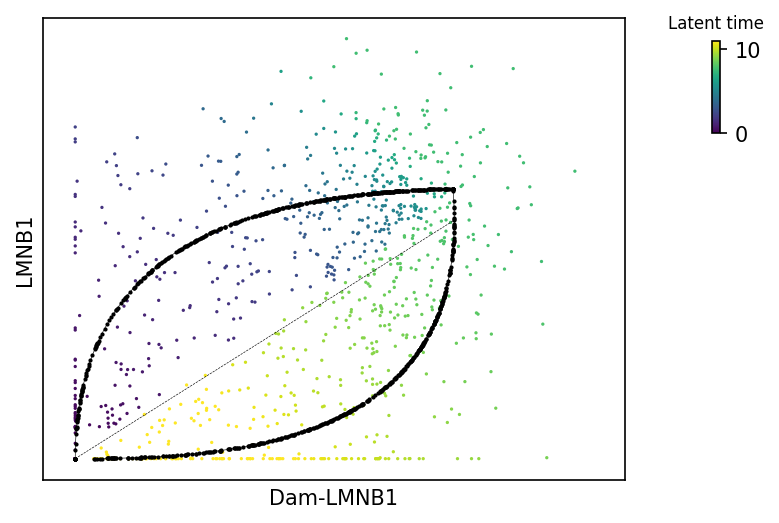

In [28]:
var = 'LAD477'

X = np.ravel(adata[:,var].layers['spliced'])
y = np.ravel(adata[:,var].layers['unspliced'])

f, ax = plt.subplots(figsize=(5,4), **kwargs)

sc = ax.scatter(X,
           y, 
           c=np.ravel(adata[:,var].layers['fit_t']), 
           cmap='viridis', 
           s=2.5, 
           vmin=0,
           vmax=11,
           linewidth=0, 
           edgecolor='k'
)
ax.set_xlim(right=5)

dx = np.ravel(adata[:,var].layers['steady_state_velocity'])
dy = np.ravel(adata[:,var].layers['steady_state_velocity'])
dy = np.zeros(adata.n_obs)

X = np.stack([X, y]).T
V = np.stack([dx, dy]).T

scv.pl.scatter(adata, 
               basis=var,
               color='fit_t', 
               color_map='viridis',
               show_assignments=False, 
               size=0,
               ax=ax, 
               title='',
               colorbar=False, 
               edgecolor='k',
               linecolor='k',
               linewidth=.3, 
               xlabel='', 
               ylabel='', 
               show=False
)
ax.set_xticks([])
ax.set_yticks([])
ax.get_legend().remove()
ax.set_xlabel('Dam-LMNB1')
ax.set_ylabel('LMNB1')

axins = inset_axes(ax,
   width="1%",  # width = 5% of parent_bbox width
   height="20%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.15, .75, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(sc, ax=ax, cax=axins, pad=.06)
cbar.ax.set_title('Latent time', fontsize=8)

____

# LAD over latent time

Text(0.55, 1.01, 'LAD477')

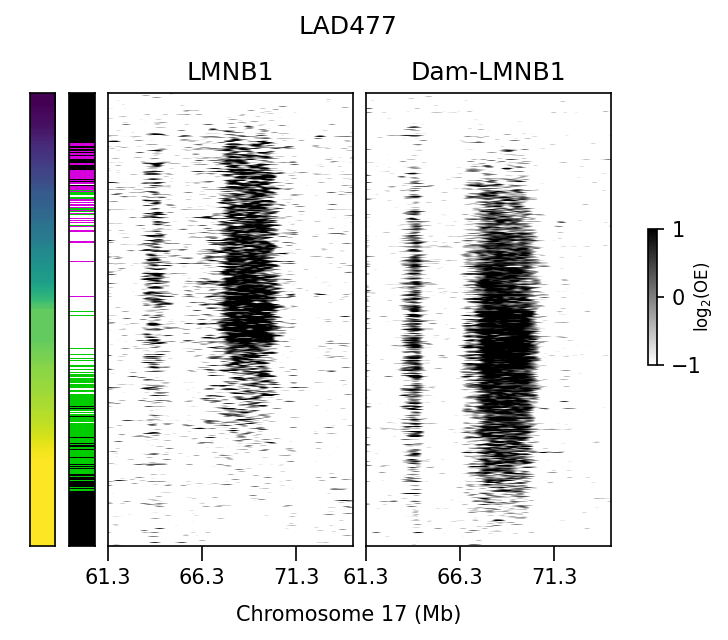

In [33]:
var = 'LAD477'
index = int(var.split('LAD')[-1])

_argsort = np.argsort(np.ravel(adata[:,var].layers['fit_t']))

chrom, start, end = lads.loc[index,:2]
ws = int((start - 6e6) / BINSIZE)
we = int((end + 4e6) / BINSIZE)

X = np.array([damid_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])
y = np.array([chic_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])

xaxis = np.arange(ws*BINSIZE,we*BINSIZE,BINSIZE) / 1e6
yaxis = np.arange(anno_sub.shape[0])

f, ax = plt.subplots(1, 
                     4, 
                     figsize=(5,4), 
                     gridspec_kw={'wspace':.1,'width_ratios':[.05,.05,.475,.475]}, 
                     **kwargs
)
ax[0].pcolorfast(np.ravel(adata[:,var].layers['fit_t'])[_argsort].reshape(-1,1), 
                   cmap='viridis', 
                   vmin=0, 
                   vmax=10,
)
ax[1].pcolorfast(Zlads[:,index][_argsort].reshape(-1,1), 
                 cmap=cmap.from_list('cbar',list(coldict.values())), 
)
ax[2].imshow(np.log2(y)[_argsort], 
               vmin=-1, 
               vmax=1, 
               aspect='auto', 
               cmap='binary', 
               origin='lower',
               interpolation='bilinear',
               extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
)
im = ax[3].imshow(np.log2(X)[_argsort], 
               vmin=-1, 
               vmax=1, 
               aspect='auto', 
               origin='lower',
               cmap='binary', 
               interpolation='bilinear',
               extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
)
for i in range(ax.size):
    ax[i].invert_yaxis()
    ax[i].tick_params(**tick_kwargs)
    ax[i].set_yticks([])
ax[2].set_title('LMNB1')
ax[3].set_title('Dam-LMNB1')
ax[2].margins(x=0)
ax[3].margins(x=0)

f.text(0.55, 0.0, 'Chromosome %s (Mb)' %chrom, ha='center')
ax[0].set_xticks([])
ax[1].set_xticks([])

ax[2].set_xticks(np.arange((ws*BINSIZE) / 1e6, (we*BINSIZE) / 1e6, 5))
ax[3].set_xticks(np.arange((ws*BINSIZE) / 1e6, (we*BINSIZE) / 1e6, 5))

axins = inset_axes(ax[3],
   width="2.5%", 
   height="30%",
   loc='lower left',
   bbox_to_anchor=(1.15, .4, 1.5, 1),
   bbox_transform=ax[3].transAxes,
   borderpad=0,
   )
cbar = f.colorbar(im, ax=ax[3], cax=axins, pad=.06, ticks=[-1,0,1])
cbar.ax.set_ylabel('log$_{{{2}}}$(OE)', fontsize=8, labelpad=-5)

f.suptitle(var, x=.55, y=1.01)

______

# LAD latent time pairwise correlation

In [34]:
def pearsonr_matrix_dot(M):
    x = M
    y = M
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    cov /= np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])
    cov[np.isnan(cov)] = 0
    cov[np.isinf(cov)] = 0
    return cov

In [35]:
p = pearsonr_matrix_dot(adata.layers['fit_t'].T)

p.shape

(547, 547)

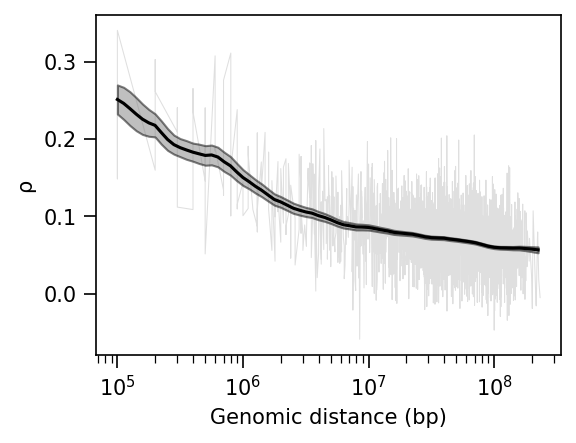

In [36]:
lads_idx = ~np.isin(lads[0],['8','X']) & (lads[3] < 2e6).values #exclude diploid and sex-chromosome 
triu_idx = np.triu_indices(lads_idx.sum(), 1)

d = (lads.loc[lads_idx, 1].values - lads.loc[lads_idx, 2].values.reshape(-1,1))
intra_idx2d = (lads.loc[lads_idx, 0].values == lads.loc[lads_idx, 0].values.reshape(-1,1))

_argsort = np.argsort(d[triu_idx])
intra_idx2d = intra_idx2d[triu_idx][_argsort]

X = d[triu_idx][_argsort][intra_idx2d]
y = p[lads_idx][:,lads_idx][triu_idx][_argsort][intra_idx2d]

xhat, yhat, yhat_sem = sccu.RNR(np.log10(X), 
                                y, 
                                _RADIUS=.15, 
                                step=.05
)
f, ax = plt.subplots(figsize=(4,3), 
                     **kwargs
)
ax.plot(X, 
        y, 
        zorder=0,
        lw=.5, 
        color='gray', alpha=.25
)
ax.fill_between(10**xhat, 
                yhat-yhat_sem, 
                yhat+yhat_sem, 
                color='gray', 
                alpha=.5, 
                zorder=1, 
                edgecolor='k',
                lw=1
)
ax.plot(10**xhat, 
        yhat, 
        zorder=1,
        color='k'
)

ax.set_xlabel('Genomic distance (bp)')
ax.set_ylabel('ρ')
ax.set_xscale('log')
ax.tick_params(**tick_kwargs)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

______

# LAD over latent time

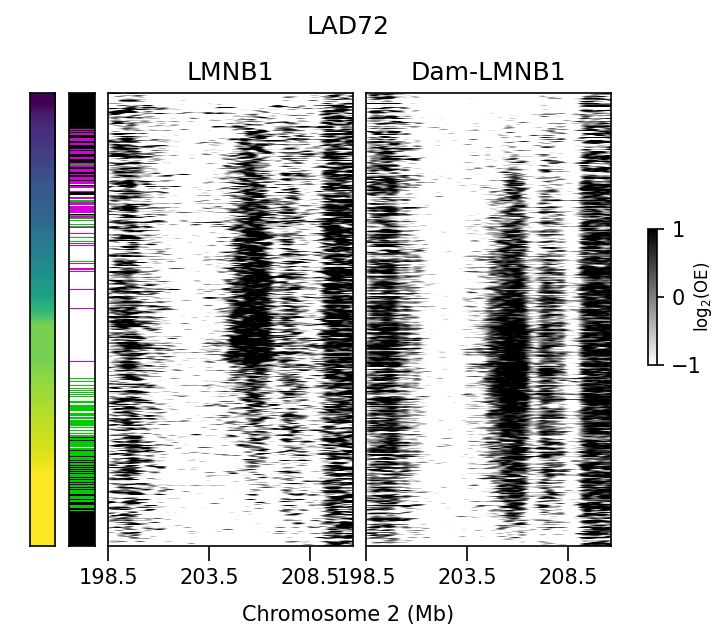

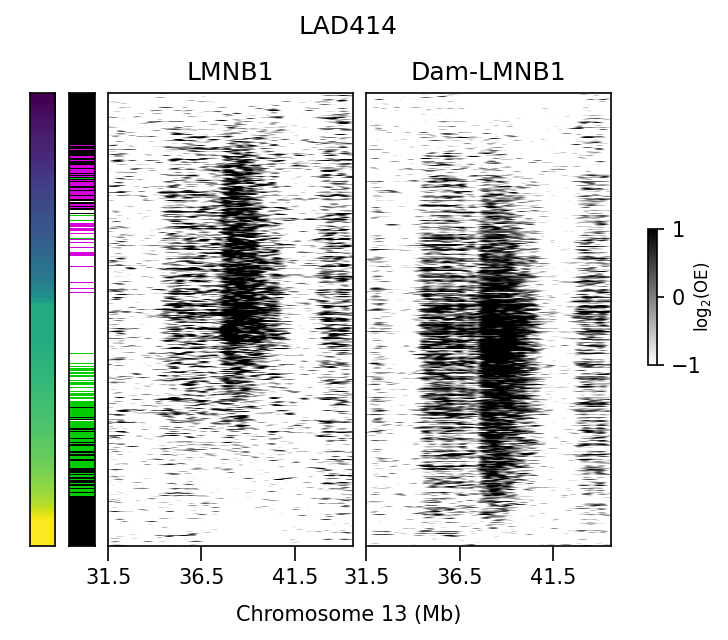

In [37]:
for var in ['LAD72','LAD414']:
    index = int(var.split('LAD')[-1])

    _argsort = np.argsort(np.ravel(adata[:,var].layers['fit_t']))

    chrom, start, end = lads.loc[index,:2]
    ws = int((start - 6e6) / BINSIZE)
    we = int((end + 4e6) / BINSIZE)

    X = np.array([damid_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])
    y = np.array([chic_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])

    xaxis = np.arange(ws*BINSIZE,we*BINSIZE,BINSIZE) / 1e6
    yaxis = np.arange(anno_sub.shape[0])

    f, ax = plt.subplots(1, 
                         4, 
                         figsize=(5,4), 
                         gridspec_kw={'wspace':.1,'width_ratios':[.05,.05,.475,.475]}, 
                         **kwargs
    )
    ax[0].pcolorfast(np.ravel(adata[:,var].layers['fit_t'])[_argsort].reshape(-1,1), 
                       cmap='viridis', 
                       vmin=0, 
                       vmax=10,
    )
    ax[1].pcolorfast(Zlads[:,index][_argsort].reshape(-1,1), 
                     cmap=cmap.from_list('cbar',list(coldict.values())), 
    )
    ax[2].imshow(np.log2(y)[_argsort], 
                   vmin=-1, 
                   vmax=1, 
                   aspect='auto', 
                   cmap='binary', 
                   origin='lower',
                   interpolation='bilinear',
                   extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
    )
    im = ax[3].imshow(np.log2(X)[_argsort], 
                   vmin=-1, 
                   vmax=1, 
                   aspect='auto', 
                   origin='lower',
                   cmap='binary', 
                   interpolation='bilinear',
                   extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
    )
    for i in range(ax.size):
        ax[i].invert_yaxis()
        ax[i].tick_params(**tick_kwargs)
        ax[i].set_yticks([])
    ax[2].set_title('LMNB1')
    ax[3].set_title('Dam-LMNB1')
    ax[2].margins(x=0)
    ax[3].margins(x=0)

    f.text(0.55, 0.0, 'Chromosome %s (Mb)' %chrom, ha='center')
    ax[0].set_xticks([])
    ax[1].set_xticks([])

    ax[2].set_xticks(np.arange((ws*BINSIZE) / 1e6, (we*BINSIZE) / 1e6, 5))
    ax[3].set_xticks(np.arange((ws*BINSIZE) / 1e6, (we*BINSIZE) / 1e6, 5))

    axins = inset_axes(ax[3],
       width="2.5%",  
       height="30%",
       loc='lower left',
       bbox_to_anchor=(1.15, .4, 1.5, 1),
       bbox_transform=ax[3].transAxes,
       borderpad=0,
       )
    cbar = f.colorbar(im, ax=ax[3], cax=axins, pad=.06, ticks=[-1,0,1])
    cbar.ax.set_ylabel('log$_{{{2}}}$(OE)', fontsize=8, labelpad=-5)

    f.suptitle(var, x=.55, y=1.01)

_____

# LAD latent time start/end

In [31]:
import ruptures as rpt
from cooltools import numutils

In [ ]:
ruptures.Binseg

In [32]:
window = 1e6

lads_idx = ((~np.isin(lads[0], ['8','X'])) & 
            (lads[3] > .75e6) & 
            (lads[3] < 3.5e6) & 
            (lads[1] >= window) & 
            ((lads[2] + window) < np.array([chromsizes[c] for c in lads[0]]))
)

lads_idx.sum()

280

In [33]:
_window = .5e6
wbs = int(_window / BINSIZE)

a2d_sseg = np.zeros((lads_idx.sum(),100))
a2d_eseg = np.zeros((lads_idx.sum(),100))
assert a2d_sseg.shape[1] == 100, '`numutils.zoom_array` based on shape (,100)'
for i,index in enumerate(tqdm(lads[lads_idx].index)):
    chrom, start, end = lads.loc[index,:2]
    ws = (start//BINSIZE) - wbs
    we = (end//BINSIZE) + wbs
    
    _argsort = np.argsort(adata.layers['fit_t'][:,index])
    
    signal1d = gaussian_filter(Xlads[:,index][_argsort].astype(float), 10)
    binseg = rpt.Binseg(model='l2').fit(signal1d)
    bkps = binseg.predict(n_bkps=2)
    sseg, eseg, _ = bkps #start and end of LAD segment 
    
    X = np.array([damid_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])[_argsort]
    y = np.array([chic_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])[_argsort]
    
    l = X[sseg-75:sseg+10,:wbs].mean(0)
    m = X[sseg-75:sseg+10,wbs:-wbs].mean(0)
    r = X[sseg-75:sseg+10,-wbs:].mean(0)

    profile = np.r_[numutils.zoom_array(l, (25,)), 
                    numutils.zoom_array(m, (50,)), 
                    numutils.zoom_array(r, (25,))
    ]
    a2d_sseg[i] = profile
    
    l = X[eseg-10:eseg+75,:wbs].mean(0)
    m = X[eseg-10:eseg+75,wbs:-wbs].mean(0)
    r = X[eseg-10:eseg+75,-wbs:].mean(0)

    profile = np.r_[numutils.zoom_array(l, (25,)), 
                    numutils.zoom_array(m, (50,)), 
                    numutils.zoom_array(r, (25,))
    ]
    a2d_eseg[i] = profile

  0%|          | 0/280 [00:00<?, ?it/s]

In [34]:
_window = .5e6
wbs = int(_window / BINSIZE)

a2d_sseg = np.zeros((lads_idx.sum(),100))
a2d_eseg = np.zeros((lads_idx.sum(),100))
lads_argmax = np.zeros((lads_idx.sum(),4), dtype=object)
assert a2d_sseg.shape[1] == 100, '`numutils.zoom_array` based on shape (,100)'
for i,index in enumerate(tqdm(lads[lads_idx].index)):
    chrom, start, end = lads.loc[index,:2]
    ws = (start//BINSIZE) - wbs
    we = (end//BINSIZE) + wbs
    
    _argsort = np.argsort(adata.layers['fit_t'][:,index])
    
    signal1d = gaussian_filter(Xlads[:,index][_argsort].astype(float), 10)
    binseg = rpt.Binseg(model='l2').fit(signal1d)
    bkps = binseg.predict(n_bkps=2)
    sseg, eseg, _ = bkps #start and end of LAD segment 
    
    X = np.array([damid_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])[_argsort]
    y = np.array([chic_100kb_oe_smooth[bc][chrom][ws:we] for bc in anno_sub.index])[_argsort]
    
#     l = X[sseg-75:sseg+10,:wbs].mean(0)
#     m = X[sseg-75:sseg+10,wbs:-wbs].mean(0)
#     r = X[sseg-75:sseg+10,-wbs:].mean(0)

#     profile = np.r_[numutils.zoom_array(l, (25,)), 
#                     numutils.zoom_array(m, (50,)), 
#                     numutils.zoom_array(r, (25,))
#     ]
    
    profile = X[sseg-75:sseg+10,:].mean(0)
    profile_scaled = numutils.zoom_array(profile, (100,))
    
    a2d_sseg[i] = profile_scaled
    
    #detemine local argmax of where along the DNA the LAD emerges 
    argmax = (np.argmax(profile) + ws) * BINSIZE
    lads_argmax[i] = [chrom,start,end,argmax]
    
#     l = X[eseg-10:eseg+75,:wbs].mean(0)
#     m = X[eseg-10:eseg+75,wbs:-wbs].mean(0)
#     r = X[eseg-10:eseg+75,-wbs:].mean(0)

#     profile = np.r_[numutils.zoom_array(l, (25,)), 
#                     numutils.zoom_array(m, (50,)), 
#                     numutils.zoom_array(r, (25,))
#     ]
    
    profile = X[eseg-10:eseg+75,:].mean(0)
    profile_scaled = numutils.zoom_array(profile, (100,))
    
    a2d_eseg[i] = profile_scaled
    
lads['start_argmax'] = np.nan
lads.loc[lads_idx,'start_argmax'] = lads_argmax[:,3]

  0%|          | 0/280 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Start')

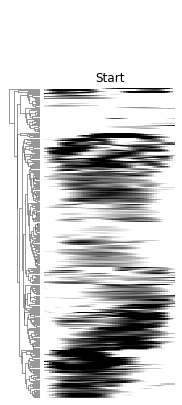

In [41]:
cg = sns.clustermap(np.log2(a2d_sseg)[:,25:75], 
                    figsize=(3,6), 
                    col_cluster=False, 
                    cmap='binary', 
                    vmin=-.3, 
                    vmax=.3, 
                    cbar_pos=None)

reorder = cg.dendrogram_row.reordered_ind
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticks([])
cg.ax_heatmap.set_title('Start')

Text(0.5, 1.0, 'End')

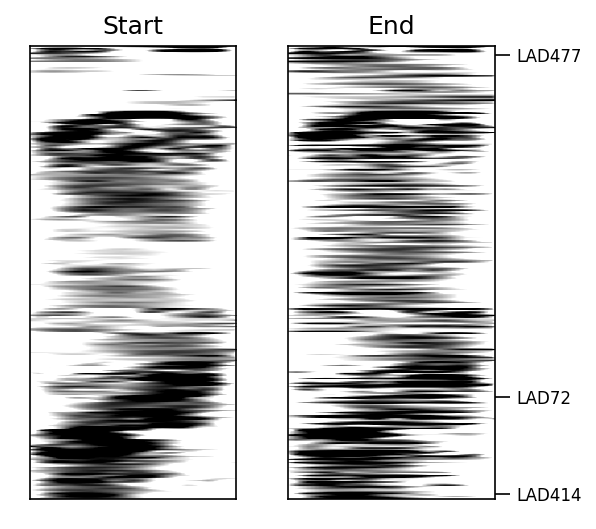

In [42]:
_argmax_argsort = np.argsort(np.argmax(a2d_sseg[:,25:75], axis=1))

f, ax = plt.subplots(1, 2, figsize=(4,4), gridspec_kw={'wspace':.25}, **kwargs)

ax[0].imshow(np.log2(a2d_sseg[reorder,:]), 
          aspect='auto',
          cmap='binary', 
          vmin=-.3, 
          vmax=.3, 
)
ax[1].imshow(np.log2(a2d_eseg[reorder,:]), 
          aspect='auto',
          cmap='binary', 
          vmin=-.3, 
          vmax=.3
)

for i in range(ax.size):
    ax[i].set_xticks([])
    ax[i].set_xlim(25,75)
    ax[i].tick_params(**tick_kwargs)
    
lads_tick = [72,414,477]
_idx = np.where(np.isin(lads[lads_idx].index[reorder], lads_tick))[0]
ax[1].set_yticks(_idx)
ax[1].set_yticklabels(['LAD%i' %i for i in lads[lads_idx].index[reorder][_idx]], fontsize=8)
ax[1].yaxis.tick_right()

ax[0].set_yticks([])

ax[0].set_title('Start')
ax[1].set_title('End')

_______

# single-cell heatmaps

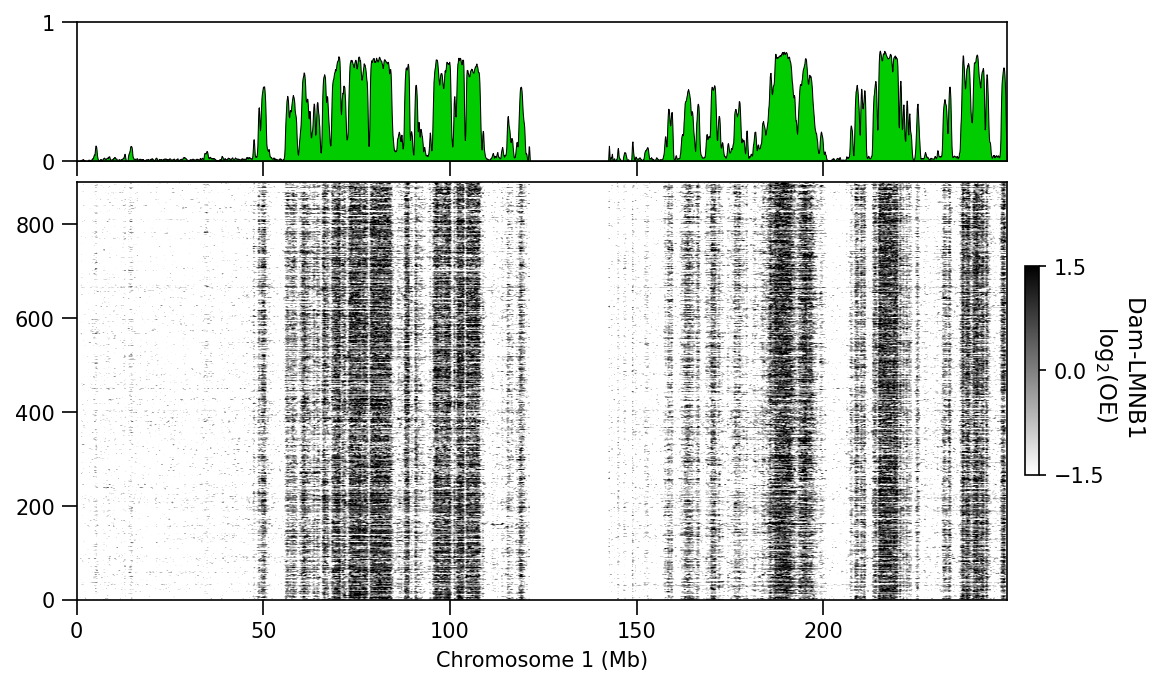

In [23]:
chrom = '1'

X = np.log2([damid_100kb_oe_smooth[bc][chrom] for bc in anno_sub.index])

xaxis = np.arange(0,chromsizes[chrom],BINSIZE) / 1e6

f, ax = plt.subplots(2, 
                     1, 
                     figsize=(8,5), 
                     gridspec_kw={'hspace':.075, 'height_ratios':[.25,.75]},
                     **kwargs
)

ax[0].fill_between(xaxis, 
                   (X > 0).mean(0), 
                   color=coldict['scDamID'], 
                   linewidth=.5,
                   edgecolor='k'
)
c = ax[1].imshow(X, 
                 vmin=-1.5, 
                 vmax=1.5, 
                 aspect='auto', 
                 origin='lower',
                 cmap='binary',
                 extent=np.hstack([xaxis[[0,-1]],[0,X.shape[0]]])
)

ax[0].margins(x=0)
ax[0].set_ylim(0)
for i in range(ax.size):
    ax[i].tick_params(**tick_kwargs)
    
ax[0].set_yticks([0,1])
#ax[0].spines[['right','left','top']].set_visible(False)
ax[1].set_yticks(range(0,801,200))


ax[1].set_xlabel('Chromosome %s (Mb)' %chrom)


axins = inset_axes(ax[1],
                   width="1%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0.3, 1.5, 1),
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )

cbar = f.colorbar(c, ax=ax[1], cax=axins, ticks=[-1.5,0,1.5])
cbar.ax.set_ylabel("Dam-LMNB1 \n log$_{{{2}}}$(OE)", fontsize=11, labelpad=20, rotation=270)
ax[0].set_xticklabels([])

plt.savefig('/Users/prullens/Documents/manuscripts/Kefalopoulou_Rullens_Dam&ChIC/revision/panels/damid_scheatmap.pdf', bbox_inches='tight')

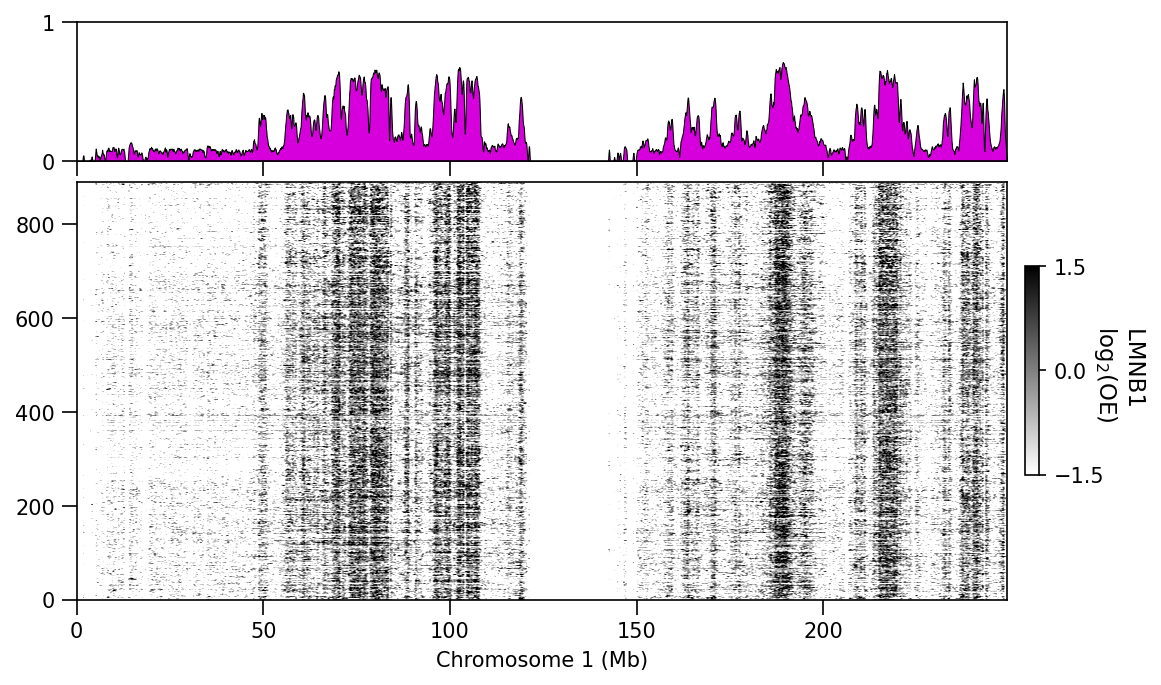

In [24]:
chrom = '1'

X = np.log2([chic_100kb_oe_smooth[bc][chrom] for bc in anno_sub.index])

xaxis = np.arange(0,chromsizes[chrom],BINSIZE) / 1e6

f, ax = plt.subplots(2, 
                     1, 
                     figsize=(8,5), 
                     gridspec_kw={'hspace':.075, 'height_ratios':[.25,.75]},
                     **kwargs
)

ax[0].fill_between(xaxis, 
                   (X > 0).mean(0), 
                   color=coldict['sortChIC'], 
                   linewidth=.5,
                   edgecolor='k'
)
c = ax[1].imshow(X, 
                 vmin=-1.5, 
                 vmax=1.5, 
                 aspect='auto', 
                 origin='lower',
                 cmap='binary',
                 extent=np.hstack([xaxis[[0,-1]],[0,X.shape[0]]])
)

ax[0].margins(x=0)
ax[0].set_ylim(0)
for i in range(ax.size):
    ax[i].tick_params(**tick_kwargs)
    
ax[0].set_yticks([0,1])
#ax[0].spines[['right','left','top']].set_visible(False)
ax[1].set_yticks(range(0,801,200))


ax[1].set_xlabel('Chromosome %s (Mb)' %chrom)


axins = inset_axes(ax[1],
                   width="1%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0.3, 1.5, 1),
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )

cbar = f.colorbar(c, ax=ax[1], cax=axins, ticks=[-1.5,0,1.5])
cbar.ax.set_ylabel("LMNB1 \n log$_{{{2}}}$(OE)", fontsize=11, labelpad=20, rotation=270)
ax[0].set_xticklabels([])

plt.savefig('/Users/prullens/Documents/manuscripts/Kefalopoulou_Rullens_Dam&ChIC/revision/panels/chic_scheatmap.pdf', bbox_inches='tight')

_____

# Contact Frequency tracks

In [45]:
dam_lads, dam_lad_coord = scct.lad_calling(cf_dam, BINSIZE, thrs=.2)
chic_lads, chic_lad_coord = scct.lad_calling(cf_chic, BINSIZE, thrs=.2)

lad_idx = np.hstack(list(dam_lads.values())).astype(bool)

lad_idx.sum(), lad_idx.size

(15826, 30376)

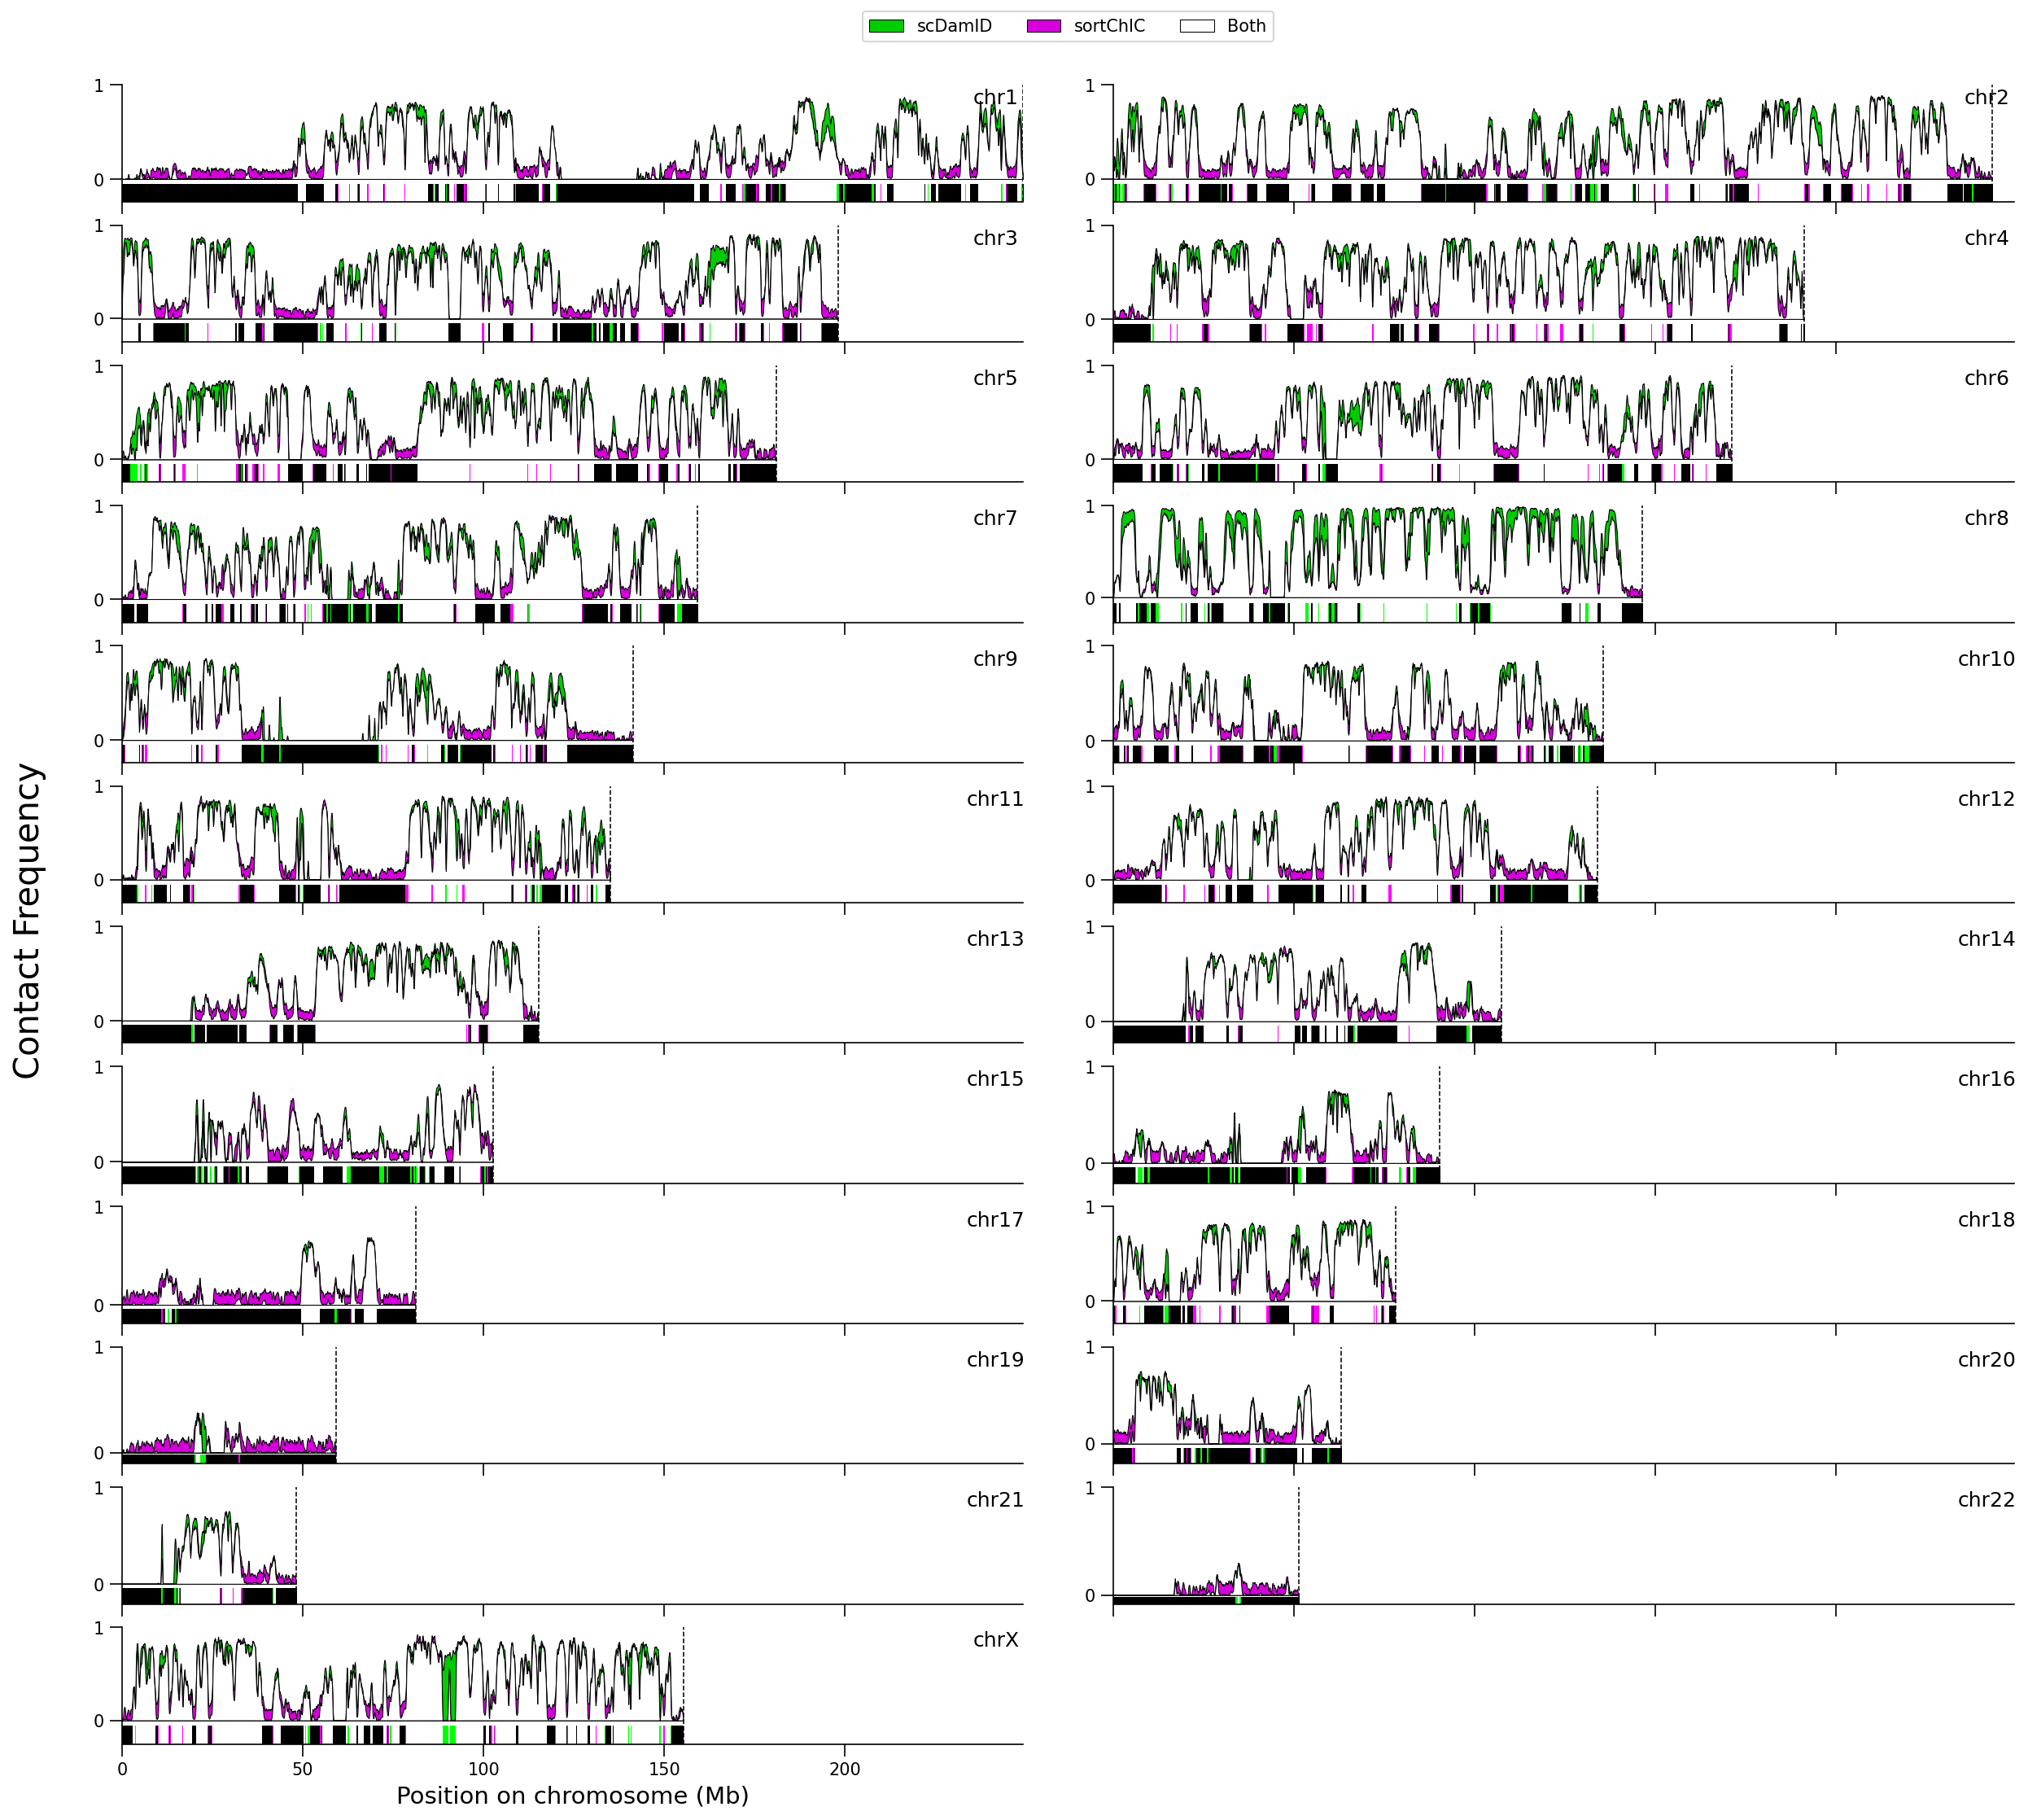

In [46]:
nrows, ncols = 12, 2
f, ax = plt.subplots(nrows, 
                     ncols, 
                     figsize=(20,18), 
                     gridspec_kw={'wspace':.1}, 
                     **kwargs)

for i,chrom in enumerate(CHROMS):
    row, col = i // 2, np.tile([0,1], len(CHROMS))[i]
    
    _min, _max = 1.3, 6
    dam, chic = cf_dam[chrom], cf_chic[chrom]
    ymax = _max + ((_max - _min) / np.max([dam, chic])) - (_max - _min)
    
    dam_scaled = (abs(_min - _max) * ((dam - np.min(dam)) / (np.max(dam) - np.min(dam)))) + _min
    chic_scaled = (abs(_min - _max) * ((chic - np.min(chic)) / (np.max(chic) - np.min(chic)))) + _min
    
    d_lad = dam_lads[chrom].astype(int)
    c_lad = chic_lads[chrom].astype(int)
    c_lad[c_lad == 1] += 1
    o_lad = d_lad + c_lad
    
    ax[row,col].fill_between(range(dam.size), 
                             _min, 
                             dam_scaled, 
                             alpha=1, 
                             label='scDamID',
                             color=coldict['scDamID'], 
                             edgecolor='k', 
                             lw=.5
    )
    ax[row,col].fill_between(range(chic.size), 
                             _min, 
                             chic_scaled, 
                             alpha=1, 
                             label='sortChIC',
                             color=coldict['sortChIC'], 
                             edgecolor='k',
                             lw=.5
    )
    ax[row,col].fill_between(range(chic.size), 
                             _min, 
                             np.minimum(dam_scaled, chic_scaled), 
                             label='Both', 
                             color=coldict['Both'],
                             edgecolor='k',
                             lw=.5
    )
    ax[row,col].set_xlim(0,cf_dam['1'].size)
    ax[row,col].spines['right'].set_visible(False)
    ax[row,col].spines['top'].set_visible(False)
    ax[row,col].pcolorfast(np.atleast_2d(o_lad), cmap=_cmap, alpha=1)
    
    ax[row,col].set_ylim(0, ymax)
    ax[row,col].set_yticks([_min, ymax])
    ax[row,col].set_yticklabels([0, 1])
    ax[row,col].set_title('chr%s' %chrom, x=.97, y=0.75)
    ax[row,col].axvline(dam.size, color='k', lw=.75, linestyle='--')
    ax[row,col].tick_params(length=7)
    if row != 11:
        ax[row,col].set_xticklabels([])
        
ax[-1,-1].set_xlim(0,cf_dam['1'].size)
ax[-1,-1].spines['right'].set_visible(False)
ax[-1,-1].spines['top'].set_visible(False)
ax[-1,0].set_xticklabels(np.arange(0,201,50))
ax[-1,-1].set_xticklabels(np.arange(0,201,50))
ax[-1,0].set_xlabel('Position on chromosome (Mb)', fontsize=14)
ax[-1,-1].set_xlabel('Position on chromosome (Mb)', fontsize=14)
ax[0,1].legend(loc='upper center', bbox_to_anchor=(-.05, 1.7), ncol=3)

f.text(0.08, 0.5, 'Contact Frequency', va='center', rotation='vertical', fontsize=20)
ax[-1,-1].remove()

______

# Single-cell frequency

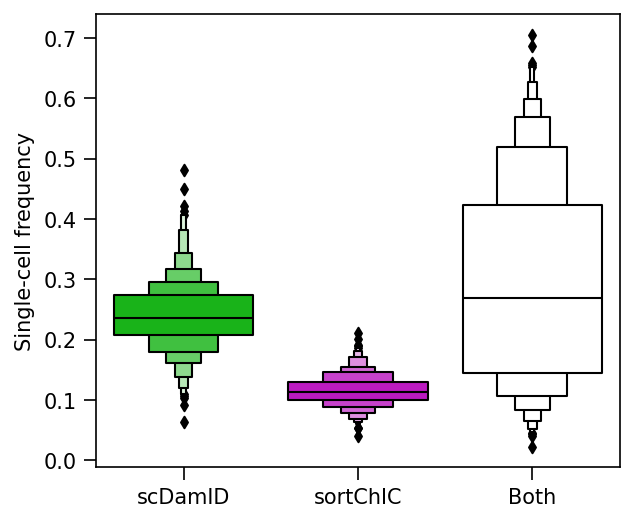

In [47]:
nonzero = (Zlads[:,lads[0] != '8'] > 0).mean(0) #chr8 is diploid in KBM7

X = np.repeat(['scDamID','sortChIC','Both'], nonzero.size)
y = np.hstack([(Zlads[:,lads[0] != '8'] == state).mean(0)  for state in (1,2,3)])

f, ax = plt.subplots(figsize=(4.5,4), 
                     **kwargs
)
sns.boxenplot(x=X, 
              y=y, 
              palette=list(coldict.values())[1:],
              showfliers=True,
              color='white',
              linewidth=1,
              line_kws={'color':'k','alpha':1},
              flier_kws={'color':'k','s':15},
              box_kws={'edgecolor':'k'}
)

ax.set_ylabel('Single-cell frequency')
ax.tick_params(**tick_kwargs)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

____

# Z-score jaccard similarity

In [48]:
def jaccard_oneaxis_xy(x, y):
    """Columns must be sites, rows species."""
    return (x & y).sum(axis=0) / (x | y).sum(axis=0)

In [49]:
import random 

def find_presences(input_matrix):
    num_rows, num_cols = input_matrix.shape
    hp = []
    iters = num_rows if num_cols >= num_rows else num_cols
    input_matrix_b = input_matrix if num_cols >= num_rows else np.transpose(input_matrix)
    for r in range(iters):
        hp.append(list(np.where(input_matrix_b[r] == 1)[0]))
    return hp

def curve_ball(input_matrix, r_hp, num_iterations=-1):
    """doi: 10.1038/ncomms5114"""
    num_rows, num_cols = input_matrix.shape
    l = range(len(r_hp))
    num_iters = 5*min(num_rows, num_cols) if num_iterations == -1 else num_iterations
    for rep in range(num_iters):
        AB = random.sample(l, 2)
        a = AB[0]
        b = AB[1]
        ab = set(r_hp[a])&set(r_hp[b]) # common elements
        l_ab=len(ab)
        l_a=len(r_hp[a])
        l_b=len(r_hp[b])
        if l_ab not in [l_a,l_b]:
            tot=list(set(r_hp[a]+r_hp[b])-ab)
            ab=list(ab)
            random.shuffle(tot)
            L=l_a-l_ab
            r_hp[a] = ab+tot[:L]
            r_hp[b] = ab+tot[L:]
    out_mat = np.zeros(input_matrix.shape, dtype=np.float32) if num_cols >= num_rows else np.zeros(input_matrix.T.shape, dtype='int8')
    for r in range(min(num_rows, num_cols)):
        out_mat[r, r_hp[r]] = 1
    result = out_mat if num_cols >= num_rows else out_mat.T
    return result

In [50]:
#take a bit to run, randomization algo is time consuming
niter = 100

Xplot, yplot, hue = list(), list(), list()
    
X = Xlads[:,lads[0] != '8'] #chr8 is diploid in KBM7
y = ylads[:,lads[0] != '8']

randint = np.random.choice(np.arange(X.shape[0]), X.shape[0], False)
yrand = y[randint]

j = jaccard_oneaxis_xy(X, y)
jrand = jaccard_oneaxis_xy(X, yrand)

j_perm = np.zeros((niter,X.shape[1]))
jrand_perm = np.zeros((niter,X.shape[1]))
for i in tqdm(range(niter)):
    hp = find_presences(y)
    y_perm = curve_ball(y, hp, num_iterations=-1).astype(int)
    j_perm[i] = jaccard_oneaxis_xy(X, y_perm)

    hp = find_presences(yrand)
    yrand_perm = curve_ball(yrand, hp, num_iterations=-1).astype(int)
    jrand_perm[i] = jaccard_oneaxis_xy(X, yrand_perm)
        
Xplot = np.repeat(['Same','Random'], X.shape[1])
yplot = (j - j_perm.mean(0)) / j_perm.std(0)
yplot = np.r_[yplot,(jrand - jrand_perm.mean(0)) / jrand_perm.std(0)]

Xplot.size, yplot.size

  0%|          | 0/100 [00:00<?, ?it/s]

(1032, 1032)

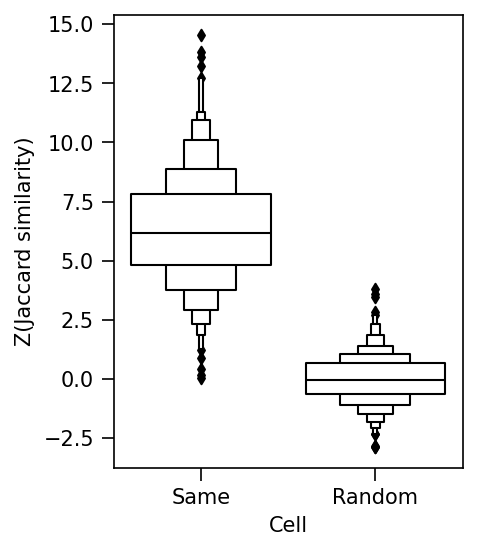

In [51]:
f, ax = plt.subplots(figsize=(3,4), 
                     **kwargs
)
sns.boxenplot(x=Xplot, 
              y=yplot, 
              palette=['white','white'],
              showfliers=True,
              linewidth=1,
              line_kws={'color':'k','alpha':1},
              flier_kws={'color':'k','s':15},
              box_kws={'edgecolor':'k'}
)
ax.set_xlabel('Cell')
ax.set_ylabel('Z(Jaccard similarity)')

#ax.legend(title='Cell', prop={'size':6}, frameon=False, bbox_to_anchor=(1,1))
ax.tick_params(**tick_kwargs)
ax.tick_params(**tick_kwargs)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

______

# Anchors and (epi)genomic features

In [37]:
gtf = pd.read_csv('/Users/prullens/metadata/Homo_sapiens.GRCh37.dna.gencode.v26lift37.basic.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_id')

In [38]:
gene_density = {c: np.zeros((chromsizes[c] // BINSIZE)+1) for c in CHROMS}
for c,s,e,tss in gtf.loc[gtf['Chromosome'].isin(CHROMS),['Chromosome','Start','End','tss']].values:
    s //= BINSIZE
    e //= BINSIZE
    tss //= BINSIZE
    gene_density[c][s:e+1] += 1

In [39]:
y2d = np.zeros(((~lads['start_argmax'].isna()).sum(),2))
for i,(c,s,e,argmax) in enumerate(lads.loc[~lads['start_argmax'].isna(),[0,1,2,'start_argmax']].values):
    s_bin = s // BINSIZE
    e_bin = e // BINSIZE
    argmax_bin = argmax // BINSIZE
    
    #`lad_idx == 1` means lad bins, `lad_idx == 2` means lad argmax bin with 2 bins flanking each side
    lad_idx = np.zeros((chromsizes[c]//BINSIZE)+1)
    lad_idx[s_bin:e_bin] = 1
    lad_idx[argmax_bin-2:argmax_bin+3] = 2
    
    y2d[i,0] = gene_density[c][lad_idx == 1].mean()
    y2d[i,1] = gene_density[c][lad_idx == 2].mean()

Text(0.5, 4.34, 'p = 9.426e-05')

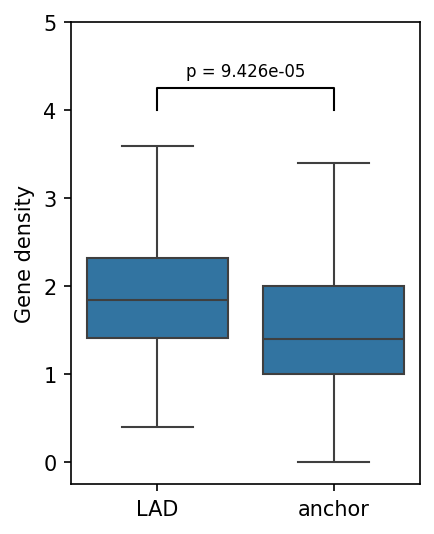

In [45]:
X = np.tile(['LAD','anchor'],(~lads['start_argmax'].isna()).sum())
y = (np.hstack(y2d))

f, ax = plt.subplots(figsize=(3,4), **kwargs)

sns.boxplot(x=X, y=y, fliersize=0)

ax.set_ylabel('Gene density')

ymin, ymax = -.25, 5
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='LAD'],y[X=='anchor'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 1, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.09, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=8)

____

In [49]:
fn = '/Users/prullens/metadata/Homo_sapiens.GRCh37.dna.primary_assembly.with_ERCC.nucleotide_content_ACGTN.binsize_100000.hdf5'

with h5py.File(fn, 'r') as f:
    nucleotide_content = {c: f[c][:] for c in CHROMS}

In [50]:
at_content = {c: nucleotide_content[c][[0,3]].sum(0) / nucleotide_content[c].sum(0) for c in CHROMS}
lads['at_content'] = [at_content[c][s//BINSIZE:e//BINSIZE].mean() for c,s,e in lads[[0,1,2]].values]

In [51]:
y2d = np.zeros(((~lads['start_argmax'].isna()).sum(),2))
for i,(c,s,e,argmax) in enumerate(lads.loc[~lads['start_argmax'].isna(),[0,1,2,'start_argmax']].values):
    s_bin = s // BINSIZE
    e_bin = e // BINSIZE
    argmax_bin = argmax // BINSIZE
    
    #`lad_idx == 1` means lad bins, `lad_idx == 2` means lad argmax bin with 2 bins flanking each side
    lad_idx = np.zeros((chromsizes[c]//BINSIZE)+1)
    lad_idx[s_bin:e_bin] = 1
    lad_idx[argmax_bin-2:argmax_bin+3] = 2
    
    y2d[i,0] = at_content[c][lad_idx == 1].mean()
    y2d[i,1] = at_content[c][lad_idx == 2].mean()

Text(0.5, 67.09, 'p = 4.848e-15')

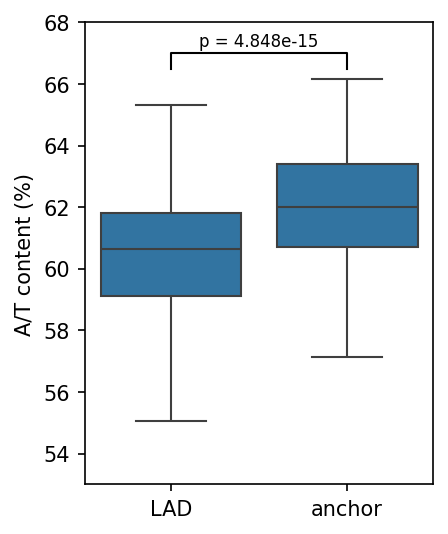

In [53]:
X = np.tile(['LAD','anchor'],(~lads['start_argmax'].isna()).sum())
y = np.hstack(y2d) *100

f, ax = plt.subplots(figsize=(3,4), **kwargs)

sns.boxplot(x=X, y=y, fliersize=0)

ax.set_ylabel('A/T content (%)')

ymin, ymax = 53, 68
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='LAD'],y[X=='anchor'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 1.5, .5
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.09, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=8)

____

In [55]:
hdf5_list = glob('/Users/prullens/Documents/projects/DamnChIC/experiments/PR20241218.*_cf.binsize_100000.hdf5')

hptm_cf, _ = scct.load_counts(hdf5_list, BINSIZE, CHROMSIZES, dtype=np.float32, disable_tqdm=True)

labels = ['H3K4me3','H3K9me3','H3K27me3']
hptm_cf = {labels[i]: hptm_cf[k] for i,k in enumerate(hptm_cf)}

In [56]:
antibody = 'H3K4me3'

y2d = np.zeros(((~lads['start_argmax'].isna()).sum(),2))
for i,(c,s,e,argmax) in enumerate(lads.loc[~lads['start_argmax'].isna(),[0,1,2,'start_argmax']].values):
    s_bin = s // BINSIZE
    e_bin = e // BINSIZE
    argmax_bin = argmax // BINSIZE
    
    #`lad_idx == 1` means lad bins, `lad_idx == 2` means lad argmax bin with 2 bins flanking each side
    lad_idx = np.zeros((chromsizes[c]//BINSIZE)+1)
    lad_idx[s_bin:e_bin] = 1
    lad_idx[argmax_bin-2:argmax_bin+3] = 2
    
    y2d[i,0] = hptm_cf[antibody][c][lad_idx == 1].mean()
    y2d[i,1] = hptm_cf[antibody][c][lad_idx == 2].mean()

Text(0.5, 0.44500000000000006, 'p = 8.467e-15')

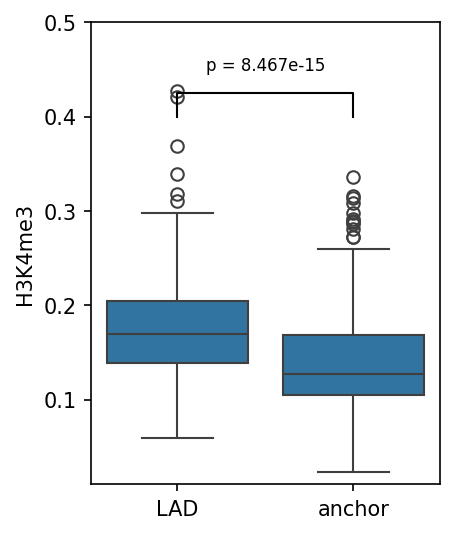

In [57]:
X = np.tile(['LAD','anchor'],(~lads['start_argmax'].isna()).sum())
y = np.hstack(y2d) #*100

f, ax = plt.subplots(figsize=(3,4), **kwargs)

sns.boxplot(x=X, y=y)

ax.set_ylabel(antibody)

ymin, ymax = .01, .5
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='LAD'],y[X=='anchor'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 0.1, .025
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=8)

____

In [58]:
antibody = 'H3K27me3'

y2d = np.zeros(((~lads['start_argmax'].isna()).sum(),2))
for i,(c,s,e,argmax) in enumerate(lads.loc[~lads['start_argmax'].isna(),[0,1,2,'start_argmax']].values):
    s_bin = s // BINSIZE
    e_bin = e // BINSIZE
    argmax_bin = argmax // BINSIZE
    
    #`lad_idx == 1` means lad bins, `lad_idx == 2` means lad argmax bin with 2 bins flanking each side
    lad_idx = np.zeros((chromsizes[c]//BINSIZE)+1)
    lad_idx[s_bin:e_bin] = 1
    lad_idx[argmax_bin-2:argmax_bin+3] = 2
    
    y2d[i,0] = hptm_cf[antibody][c][lad_idx == 1].mean()
    y2d[i,1] = hptm_cf[antibody][c][lad_idx == 2].mean()

Text(0.5, 0.8450000000000001, 'p = 6.378e-05')

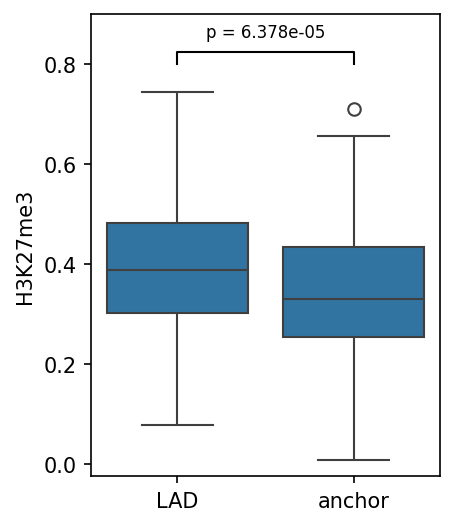

In [59]:
X = np.tile(['LAD','anchor'],(~lads['start_argmax'].isna()).sum())
y = np.hstack(y2d) #*100

f, ax = plt.subplots(figsize=(3,4), **kwargs)

sns.boxplot(x=X, y=y)

ax.set_ylabel(antibody)

ymin, ymax = -.025, .9
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='LAD'],y[X=='anchor'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 0.1, .025
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=8)

____

In [60]:
antibody = 'H3K9me3'

y2d = np.zeros(((~lads['start_argmax'].isna()).sum(),2))
for i,(c,s,e,argmax) in enumerate(lads.loc[~lads['start_argmax'].isna(),[0,1,2,'start_argmax']].values):
    s_bin = s // BINSIZE
    e_bin = e // BINSIZE
    argmax_bin = argmax // BINSIZE
    
    #`lad_idx == 1` means lad bins, `lad_idx == 2` means lad argmax bin with 2 bins flanking each side
    lad_idx = np.zeros((chromsizes[c]//BINSIZE)+1)
    lad_idx[s_bin:e_bin] = 1
    lad_idx[argmax_bin-2:argmax_bin+3] = 2
    
    y2d[i,0] = hptm_cf[antibody][c][lad_idx == 1].mean()
    y2d[i,1] = hptm_cf[antibody][c][lad_idx == 2].mean()

Text(0.5, 0.645, 'p = 1.699e-01')

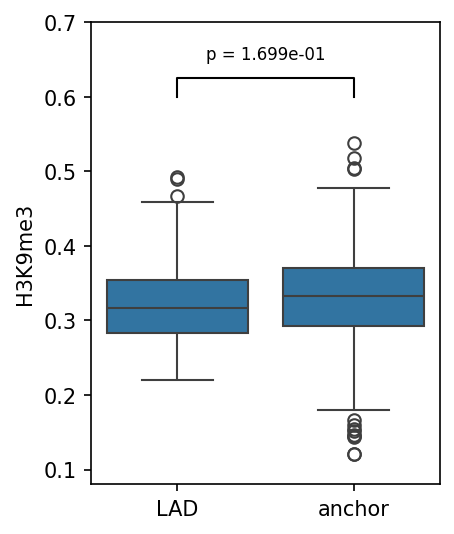

In [61]:
X = np.tile(['LAD','anchor'],(~lads['start_argmax'].isna()).sum())
y = np.hstack(y2d) #*100

f, ax = plt.subplots(figsize=(3,4), **kwargs)

sns.boxplot(x=X, y=y)

ax.set_ylabel(antibody)

ymin, ymax = .08, .7
ax.set_ylim(ymin,ymax)

#ttest All vs iLAD
p = stats.ttest_ind(y[X=='LAD'],y[X=='anchor'])[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 0.1, .025
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.02, f"p = {p:.3e}", ha='center', va='bottom', c='k', fontsize=8)